# NYC Taxi Fare Prediction - Trial 

### Load libraries

In [3]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
'''

'\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Dropout\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.optimizers.legacy import Adam\nfrom tensorflow.keras.callbacks import EarlyStopping\n'

In [72]:
# API endpoint
url = "https://data.cityofnewyork.us/resource/m6nq-qud6.json"


params = {
    "$limit": 100000,
   # "$where": "tpep_pickup_datetime >= 2022"
    "$select": "tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance, fare_amount, PULocationID, DOLocationID, passenger_count"
}

reponse = requests.get(url, params=params)

if reponse.status_code == 200:
    data = reponse.json()
    df = pd.DataFrame(data)
    print(df.head())
    #df.to_csv("nyc_taxi_data.csv", index=False)
    print("Data saved")
else:
    print(f"Failed to fetch data: {response.status_code}")

      tpep_pickup_datetime    tpep_dropoff_datetime trip_distance fare_amount  \
0  2021-01-01T00:30:10.000  2021-01-01T00:36:12.000          2.10           8   
1  2021-01-01T00:51:20.000  2021-01-01T00:52:19.000          0.20           3   
2  2021-01-01T00:43:30.000  2021-01-01T01:11:06.000         14.70          42   
3  2021-01-01T00:15:48.000  2021-01-01T00:31:01.000         10.60          29   
4  2021-01-01T00:31:49.000  2021-01-01T00:48:21.000          4.94        16.5   

  PULocationID DOLocationID passenger_count  
0          142           43               1  
1          238          151               1  
2          132          165               1  
3          138          132               0  
4           68           33               1  
Data saved


In [114]:
df

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,PULocationID,DOLocationID,passenger_count,hour,day_of_week,fare_per_mile,rush_hour
0,2021-01-01 00:30:10,2021-01-01 00:36:12,2.10,8.0,142,43,1,0,4,3.809524,0
1,2021-01-01 00:51:20,2021-01-01 00:52:19,0.20,3.0,238,151,1,0,4,15.000000,0
4,2021-01-01 00:31:49,2021-01-01 00:48:21,4.94,16.5,68,33,1,0,4,3.340081,0
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1.60,8.0,224,68,1,0,4,5.000000,0
6,2021-01-01 00:00:28,2021-01-01 00:17:28,4.10,16.0,95,157,1,0,4,3.902439,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,2021-01-04 13:45:19,2021-01-04 13:55:27,2.03,9.5,43,237,1,13,0,4.679803,0
99996,2021-01-04 13:57:16,2021-01-04 14:11:01,2.39,11.0,163,239,1,13,0,4.602510,0
99997,2021-01-04 13:23:23,2021-01-04 13:39:06,8.15,23.5,138,262,1,13,0,2.883436,0
99998,2021-01-04 13:18:40,2021-01-04 13:26:28,1.22,7.0,237,236,1,13,0,5.737705,0


In [195]:
df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,PULocationID,DOLocationID,passenger_count
count,10000,10000,10000,10000,10000,10000,10000
unique,8769,8747,1243,228,173,230,7
top,2021-01-01T12:14:13.000,2021-01-02T00:00:00.000,0.00,5.5,48,236,1
freq,4,7,212,573,502,342,7110


In [229]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,PULocationID,DOLocationID,passenger_count
0,2021-01-01T00:30:10.000,2021-01-01T00:36:12.000,2.10,8,142,43,1
1,2021-01-01T00:51:20.000,2021-01-01T00:52:19.000,0.20,3,238,151,1
2,2021-01-01T00:43:30.000,2021-01-01T01:11:06.000,14.70,42,132,165,1
3,2021-01-01T00:15:48.000,2021-01-01T00:31:01.000,10.60,29,138,132,0
4,2021-01-01T00:31:49.000,2021-01-01T00:48:21.000,4.94,16.5,68,33,1


## Data Preprocess

In [73]:
df['tpep_pickup_datetime'] = pd.to_datetime(df["tpep_pickup_datetime"])
df['tpep_dropoff_datetime'] = pd.to_datetime(df["tpep_dropoff_datetime"])

In [74]:
## Extract useful time-based features
df.loc[:, "hour"] = df["tpep_pickup_datetime"].dt.hour
df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,PULocationID,DOLocationID,passenger_count,hour,day_of_week
0,2021-01-01 00:30:10,2021-01-01 00:36:12,2.10,8,142,43,1,0,4
1,2021-01-01 00:51:20,2021-01-01 00:52:19,0.20,3,238,151,1,0,4
2,2021-01-01 00:43:30,2021-01-01 01:11:06,14.70,42,132,165,1,0,4
3,2021-01-01 00:15:48,2021-01-01 00:31:01,10.60,29,138,132,0,0,4
4,2021-01-01 00:31:49,2021-01-01 00:48:21,4.94,16.5,68,33,1,0,4


In [75]:
df['trip_distance'] = pd.to_numeric(df['trip_distance'])
df['fare_amount'] = pd.to_numeric(df['fare_amount'])
df['PULocationID'] = pd.to_numeric(df['PULocationID'])
df['DOLocationID'] = pd.to_numeric(df['DOLocationID'])
df['passenger_count'] = pd.to_numeric(df['passenger_count'])

In [9]:
# Let's investigate negative fare amount
 
df[df['fare_amount'] <= 2.5].count()  

tpep_pickup_datetime     1343
tpep_dropoff_datetime    1343
trip_distance            1343
fare_amount              1343
PULocationID             1343
DOLocationID             1343
passenger_count          1343
hour                     1343
day_of_week              1343
dtype: int64

In [59]:
df[df["fare_amount"] >= 200]

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,PULocationID,DOLocationID,passenger_count,hour,day_of_week,PU_freq,DO_freq,PU_freq_bin,DO_freq_bin,distance_hour,PU_DO_interaction,PU_cluster,DO_cluster,rush_hour
11065,2021-01-01 14:24:36,2021-01-01 14:25:05,0.00,200.0,265,265,3,14,4,58,355,Medium,Very High,0.00,20590,6,4,0
24909,2021-01-02 08:14:08,2021-01-02 09:11:02,48.68,217.5,264,265,1,8,5,879,355,Very High,Very High,389.44,312045,2,4,1
51482,2021-01-02 20:47:10,2021-01-02 21:25:39,36.74,250.0,138,265,1,20,5,3023,355,Very High,Very High,734.80,1073165,7,4,0
56026,2021-01-03 02:35:53,2021-01-03 04:24:51,73.62,207.0,132,132,1,2,6,5207,382,Very High,Very High,147.24,1989074,5,1,0
57536,2021-01-03 08:42:23,2021-01-03 10:05:44,78.27,345.0,132,265,6,8,6,5207,355,Very High,Very High,626.16,1848485,5,4,1
57683,2021-01-03 08:07:16,2021-01-03 08:07:19,0.00,275.0,265,264,1,8,6,58,771,Medium,Very High,0.00,44718,6,1,1
58374,2021-01-03 09:01:26,2021-01-03 12:45:11,215.95,800.0,10,265,1,9,6,31,355,Low,Very High,1943.55,11005,6,4,1
60641,2021-01-03 11:36:52,2021-01-03 18:30:59,267.70,708.0,148,4,1,11,6,497,517,Very High,Very High,2944.70,256949,2,1,0
62223,2021-01-03 12:08:50,2021-01-03 13:52:13,85.27,371.0,138,265,1,12,6,3023,355,Very High,Very High,1023.24,1073165,7,4,0
65405,2021-01-03 14:33:11,2021-01-03 17:25:34,90.00,238.5,132,265,1,14,6,5207,355,Very High,Very High,1260.00,1848485,5,4,0


In [ ]:
df[df["fare_amount"] <= 2.5] & df[df["fare_amount"] <= 300]

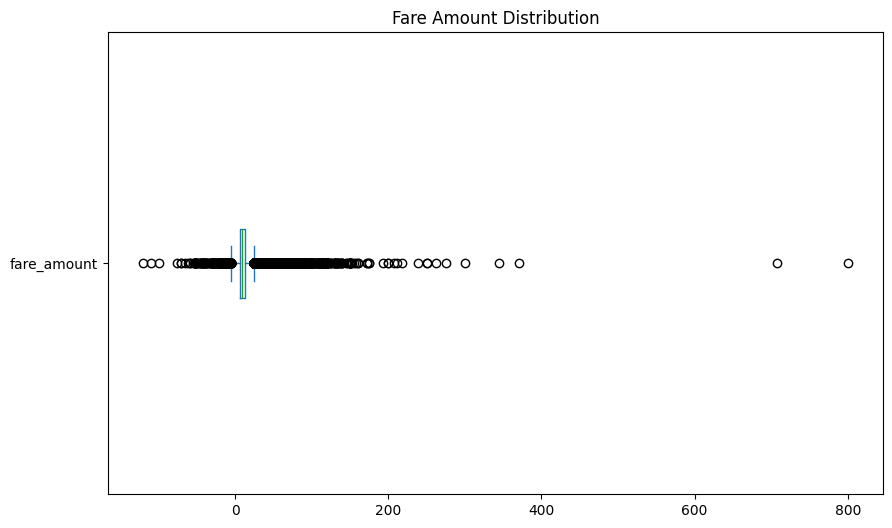

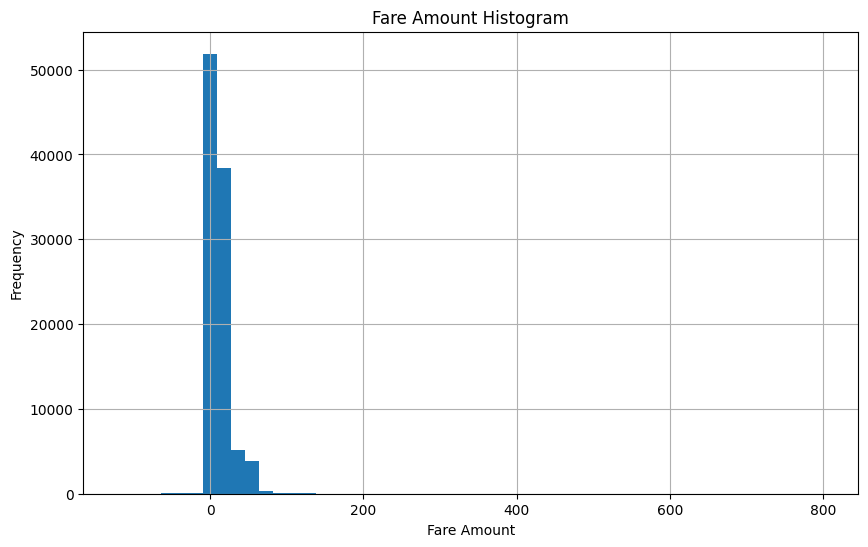

In [76]:
plt.figure(figsize=(10, 6))
df["fare_amount"].plot(kind="box", vert=False)
plt.title("Fare Amount Distribution")
plt.show()

plt.figure(figsize=(10, 6))
df["fare_amount"].hist(bins=50)
plt.title("Fare Amount Histogram")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.show()


In [61]:
Q1 = df["fare_amount"].quantile(0.25)
Q3 = df["fare_amount"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
print(f"Suggested upper bound: {upper_bound}")


Suggested upper bound: 24.75


In [91]:
## Domain knowlegde - Remove outliers

df = df[(df["fare_amount"] >= 2.5) & (df["fare_amount"] <= 24.75)]
df = df[(df["trip_distance"] > 0) & (df["trip_distance"] <= 100)]


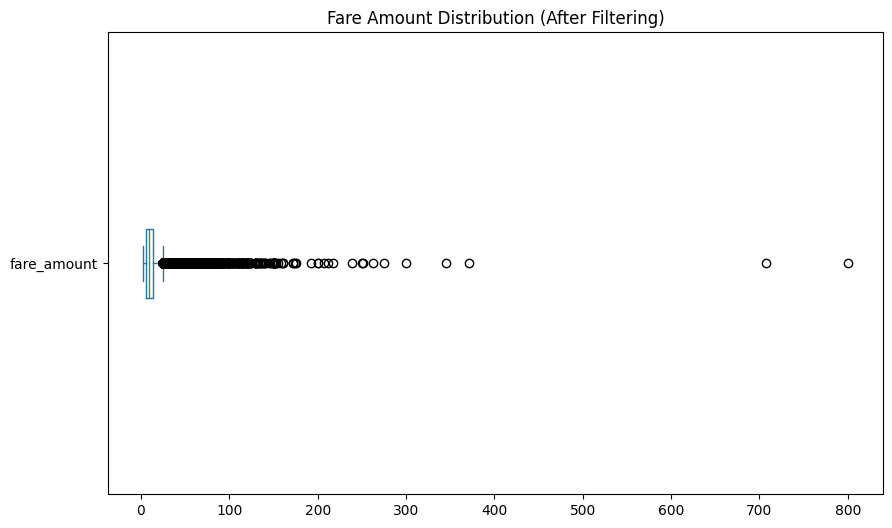

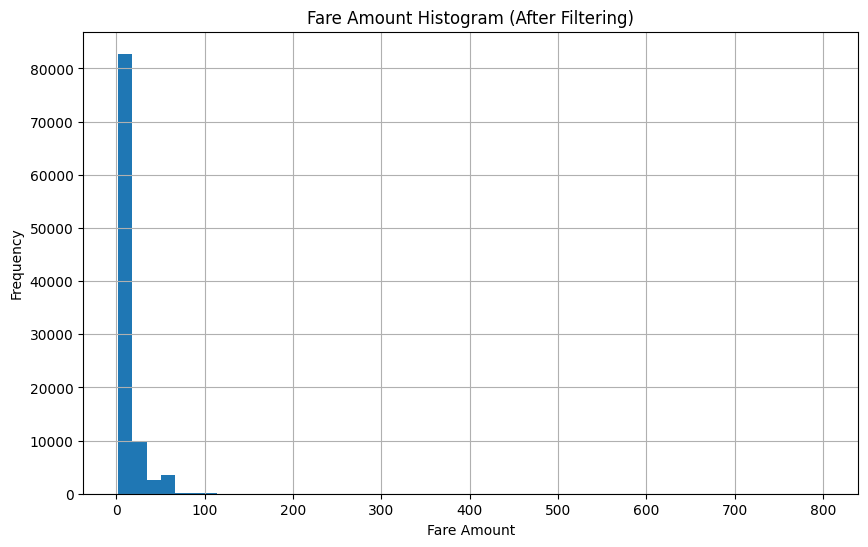

In [89]:
plt.figure(figsize=(10, 6))
df["fare_amount"].plot(kind="box", vert=False)
plt.title("Fare Amount Distribution (After Filtering)")
plt.show()

plt.figure(figsize=(10, 6))
df["fare_amount"].hist(bins=50)
plt.title("Fare Amount Histogram (After Filtering)")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.show()


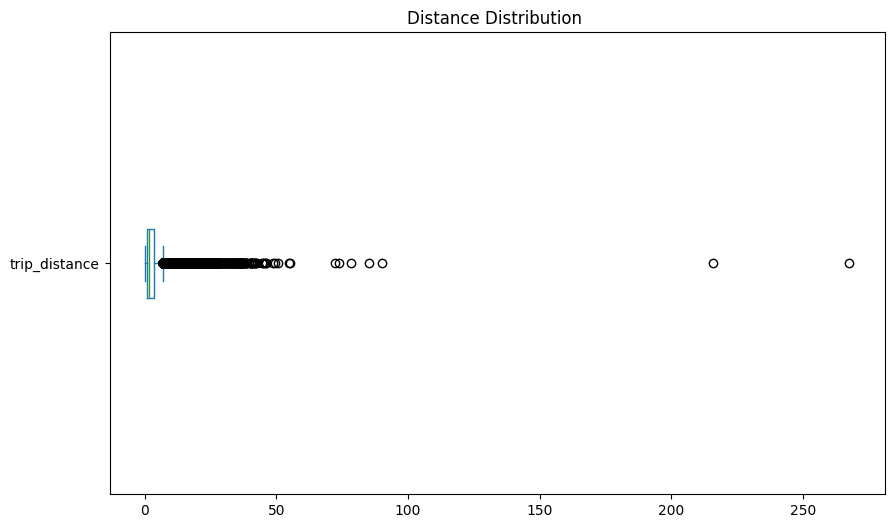

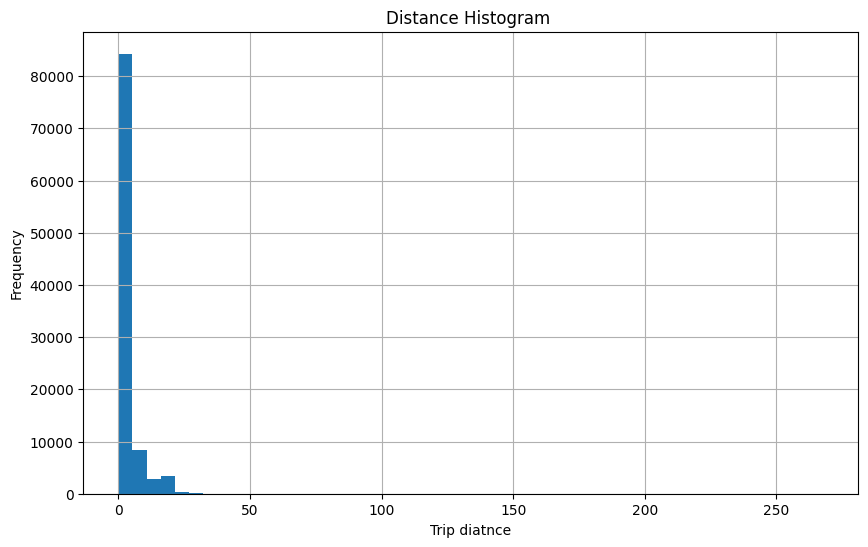

In [88]:
plt.figure(figsize=(10, 6))
df["trip_distance"].plot(kind="box", vert=False)
plt.title("Distance Distribution ")
plt.show()

plt.figure(figsize=(10, 6))
df["trip_distance"].hist(bins=50)
plt.title("Distance Histogram ")
plt.xlabel("Trip diatnce")
plt.ylabel("Frequency")
plt.show()

In [87]:
Q1 = df["trip_distance"].quantile(0.25)
Q3 = df["trip_distance"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
print(f"Suggested upper bound: {upper_bound}")

Suggested upper bound: 6.835


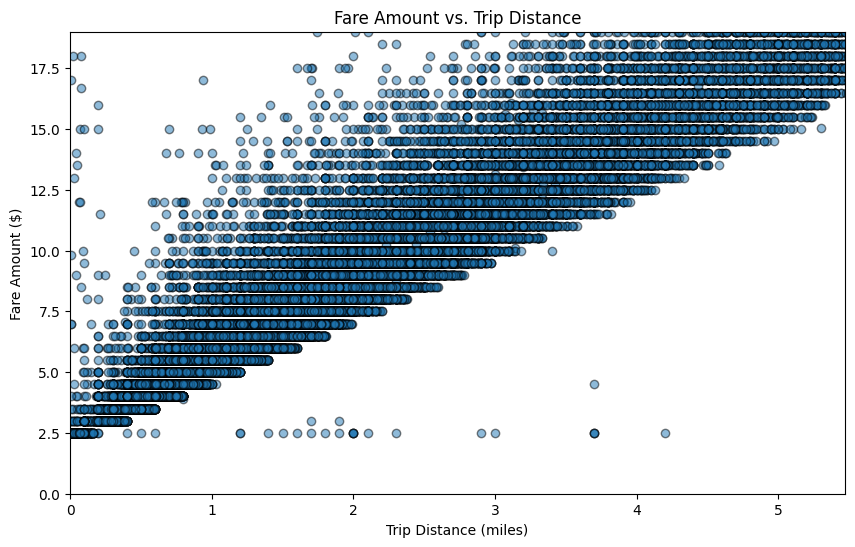

In [126]:
plt.figure(figsize=(10, 6))
plt.scatter(df["trip_distance"], df["fare_amount"], alpha=0.5, edgecolor="k")
plt.title("Fare Amount vs. Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.xlim(0, df["trip_distance"].quantile(0.95))  
plt.ylim(0, df["fare_amount"].quantile(0.95))   
plt.show()


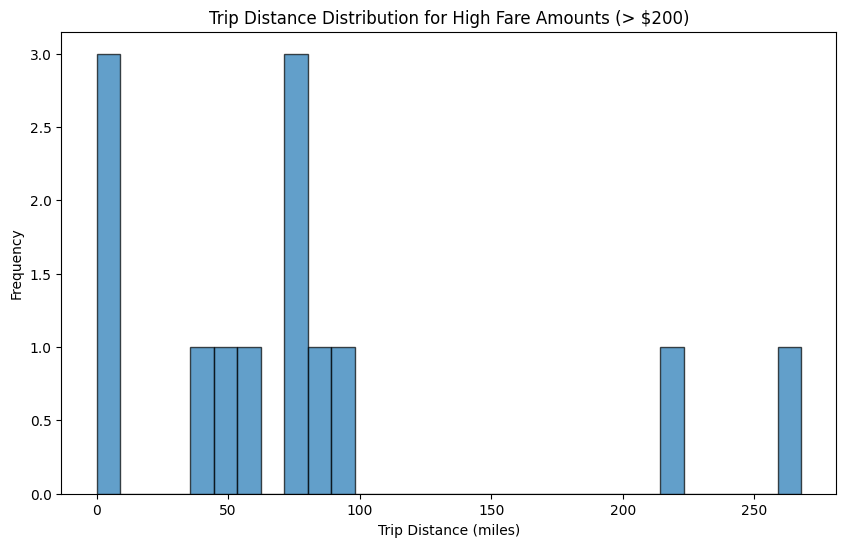

In [82]:
high_fare_data = df[df["fare_amount"] > 200]
plt.figure(figsize=(10, 6))
plt.hist(high_fare_data["trip_distance"], bins=30, edgecolor="k", alpha=0.7)
plt.title("Trip Distance Distribution for High Fare Amounts (> $200)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Frequency")
plt.show()


In [94]:
df.shape


(87406, 10)

In [11]:
### Filtering unreasonable passenger counts (0 or more than 7)
df = df[df["passenger_count"] > 0]
df.shape




(97277, 9)

In [12]:
# Frequency encoding for PULocationID and DOLocationID - This will help us capture the popularity of demand of each location
pickup_freq = df["PULocationID"].value_counts()
dropoff_freq = df["DOLocationID"].value_counts()

In [65]:
pickup_freq

PULocationID
132    5207
186    4433
236    4206
237    4193
239    3493
       ... 
150       1
81        1
190       1
121       1
34        1
Name: count, Length: 225, dtype: int64

In [14]:
df["PULocationID"].map(pickup_freq)

0        3208
1        2987
2        5207
4        2550
5         193
         ... 
99995    1889
99996    1750
99997    3023
99998    4193
99999    4433
Name: PULocationID, Length: 97277, dtype: int64

In [15]:
df["PU_freq"] = df["PULocationID"].map(pickup_freq)
df["DO_freq"] = df["DOLocationID"].map(dropoff_freq)
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,PULocationID,DOLocationID,passenger_count,hour,day_of_week,PU_freq,DO_freq
0,2021-01-01 00:30:10,2021-01-01 00:36:12,2.10,8.0,142,43,1,0,4,3208,1413
1,2021-01-01 00:51:20,2021-01-01 00:52:19,0.20,3.0,238,151,1,0,4,2987,1494
2,2021-01-01 00:43:30,2021-01-01 01:11:06,14.70,42.0,132,165,1,0,4,5207,34
4,2021-01-01 00:31:49,2021-01-01 00:48:21,4.94,16.5,68,33,1,0,4,2550,201
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1.60,8.0,224,68,1,0,4,193,2198


In [16]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,PULocationID,DOLocationID,passenger_count,hour,day_of_week,PU_freq,DO_freq
0,2021-01-01 00:30:10,2021-01-01 00:36:12,2.10,8.0,142,43,1,0,4,3208,1413
1,2021-01-01 00:51:20,2021-01-01 00:52:19,0.20,3.0,238,151,1,0,4,2987,1494
2,2021-01-01 00:43:30,2021-01-01 01:11:06,14.70,42.0,132,165,1,0,4,5207,34
4,2021-01-01 00:31:49,2021-01-01 00:48:21,4.94,16.5,68,33,1,0,4,2550,201
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1.60,8.0,224,68,1,0,4,193,2198


In [56]:
df.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,PULocationID,DOLocationID,passenger_count,hour,day_of_week,PU_freq,DO_freq,distance_hour,PU_DO_interaction,PU_cluster,DO_cluster,rush_hour
count,97277,97277,97277.000000,97277.000000,97277.000000,97277.000000,97277.000000,97277.000000,97277.000000,97277.000000,97277.000000,97277.000000,9.727700e+04,97277.000000,97277.000000,97277.000000
mean,2021-01-03 00:24:50.488645888,2021-01-03 00:39:31.737923584,3.294844,12.761982,161.605621,158.944910,1.496387,13.149676,4.009807,2470.839592,1817.118014,44.558532,4.609389e+06,3.899144,4.172744,0.311872
min,2020-12-31 13:44:02,2020-12-31 13:53:43,0.000000,2.500000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,2021-01-02 08:56:04,2021-01-02 09:08:18,1.010000,6.000000,114.000000,100.000000,1.000000,10.000000,4.000000,1660.000000,986.000000,11.400000,1.434516e+06,2.000000,2.000000,0.000000
50%,2021-01-02 19:42:46,2021-01-02 19:57:59,1.780000,8.500000,161.000000,161.000000,1.000000,13.000000,5.000000,2193.000000,1719.000000,21.580000,3.776132e+06,4.000000,4.000000,0.000000
75%,2021-01-03 18:33:45,2021-01-03 18:49:38,3.340000,13.500000,234.000000,236.000000,2.000000,17.000000,5.000000,3208.000000,2649.000000,42.800000,6.704364e+06,6.000000,6.000000,1.000000
max,2021-03-01 07:59:46,2021-03-01 08:04:30,267.700000,800.000000,265.000000,265.000000,8.000000,23.000000,6.000000,5207.000000,4330.000000,2944.700000,2.254631e+07,9.000000,9.000000,1.000000
std,NaN,NaN,4.445917,12.897766,67.043597,73.335152,1.082848,5.073678,2.127627,1304.094997,1095.572238,69.942142,3.918836e+06,2.710885,2.892411,0.463260


## EDA

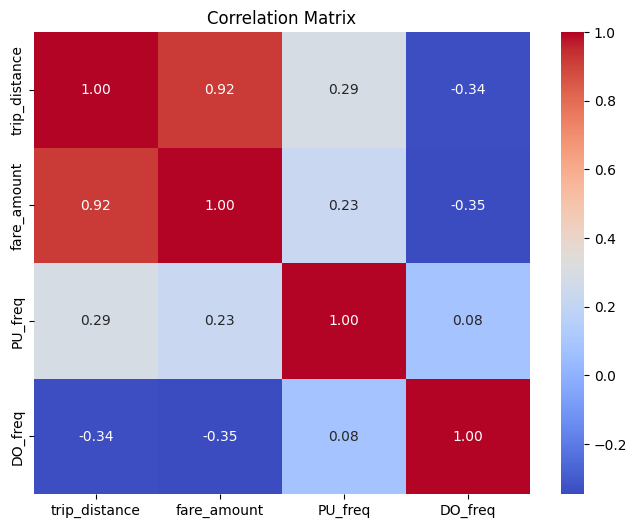

In [17]:
# Correlation matrix
correlation_matrix = df[["trip_distance", "fare_amount", "PU_freq", "DO_freq"]].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [18]:
## Adding these bin freqencies for visualization purpose
df["PU_freq_bin"] = pd.cut(df["PU_freq"], bins=[0, 50, 100, 150, float("inf")], labels = ["Low", "Medium", "High", "Very High"])
df["DO_freq_bin"] = pd.cut(df["DO_freq"], bins=[0, 50, 100, 150, float("inf")], labels = ["Low", "Medium", "High", "Very High"])
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,PULocationID,DOLocationID,passenger_count,hour,day_of_week,PU_freq,DO_freq,PU_freq_bin,DO_freq_bin
0,2021-01-01 00:30:10,2021-01-01 00:36:12,2.10,8.0,142,43,1,0,4,3208,1413,Very High,Very High
1,2021-01-01 00:51:20,2021-01-01 00:52:19,0.20,3.0,238,151,1,0,4,2987,1494,Very High,Very High
2,2021-01-01 00:43:30,2021-01-01 01:11:06,14.70,42.0,132,165,1,0,4,5207,34,Very High,Low
4,2021-01-01 00:31:49,2021-01-01 00:48:21,4.94,16.5,68,33,1,0,4,2550,201,Very High,Very High
5,2021-01-01 00:16:29,2021-01-01 00:24:30,1.60,8.0,224,68,1,0,4,193,2198,Very High,Very High


/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_55354/777467252.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="day_of_week",data = df, palette = "viridis" ,ax = axes[1,1])


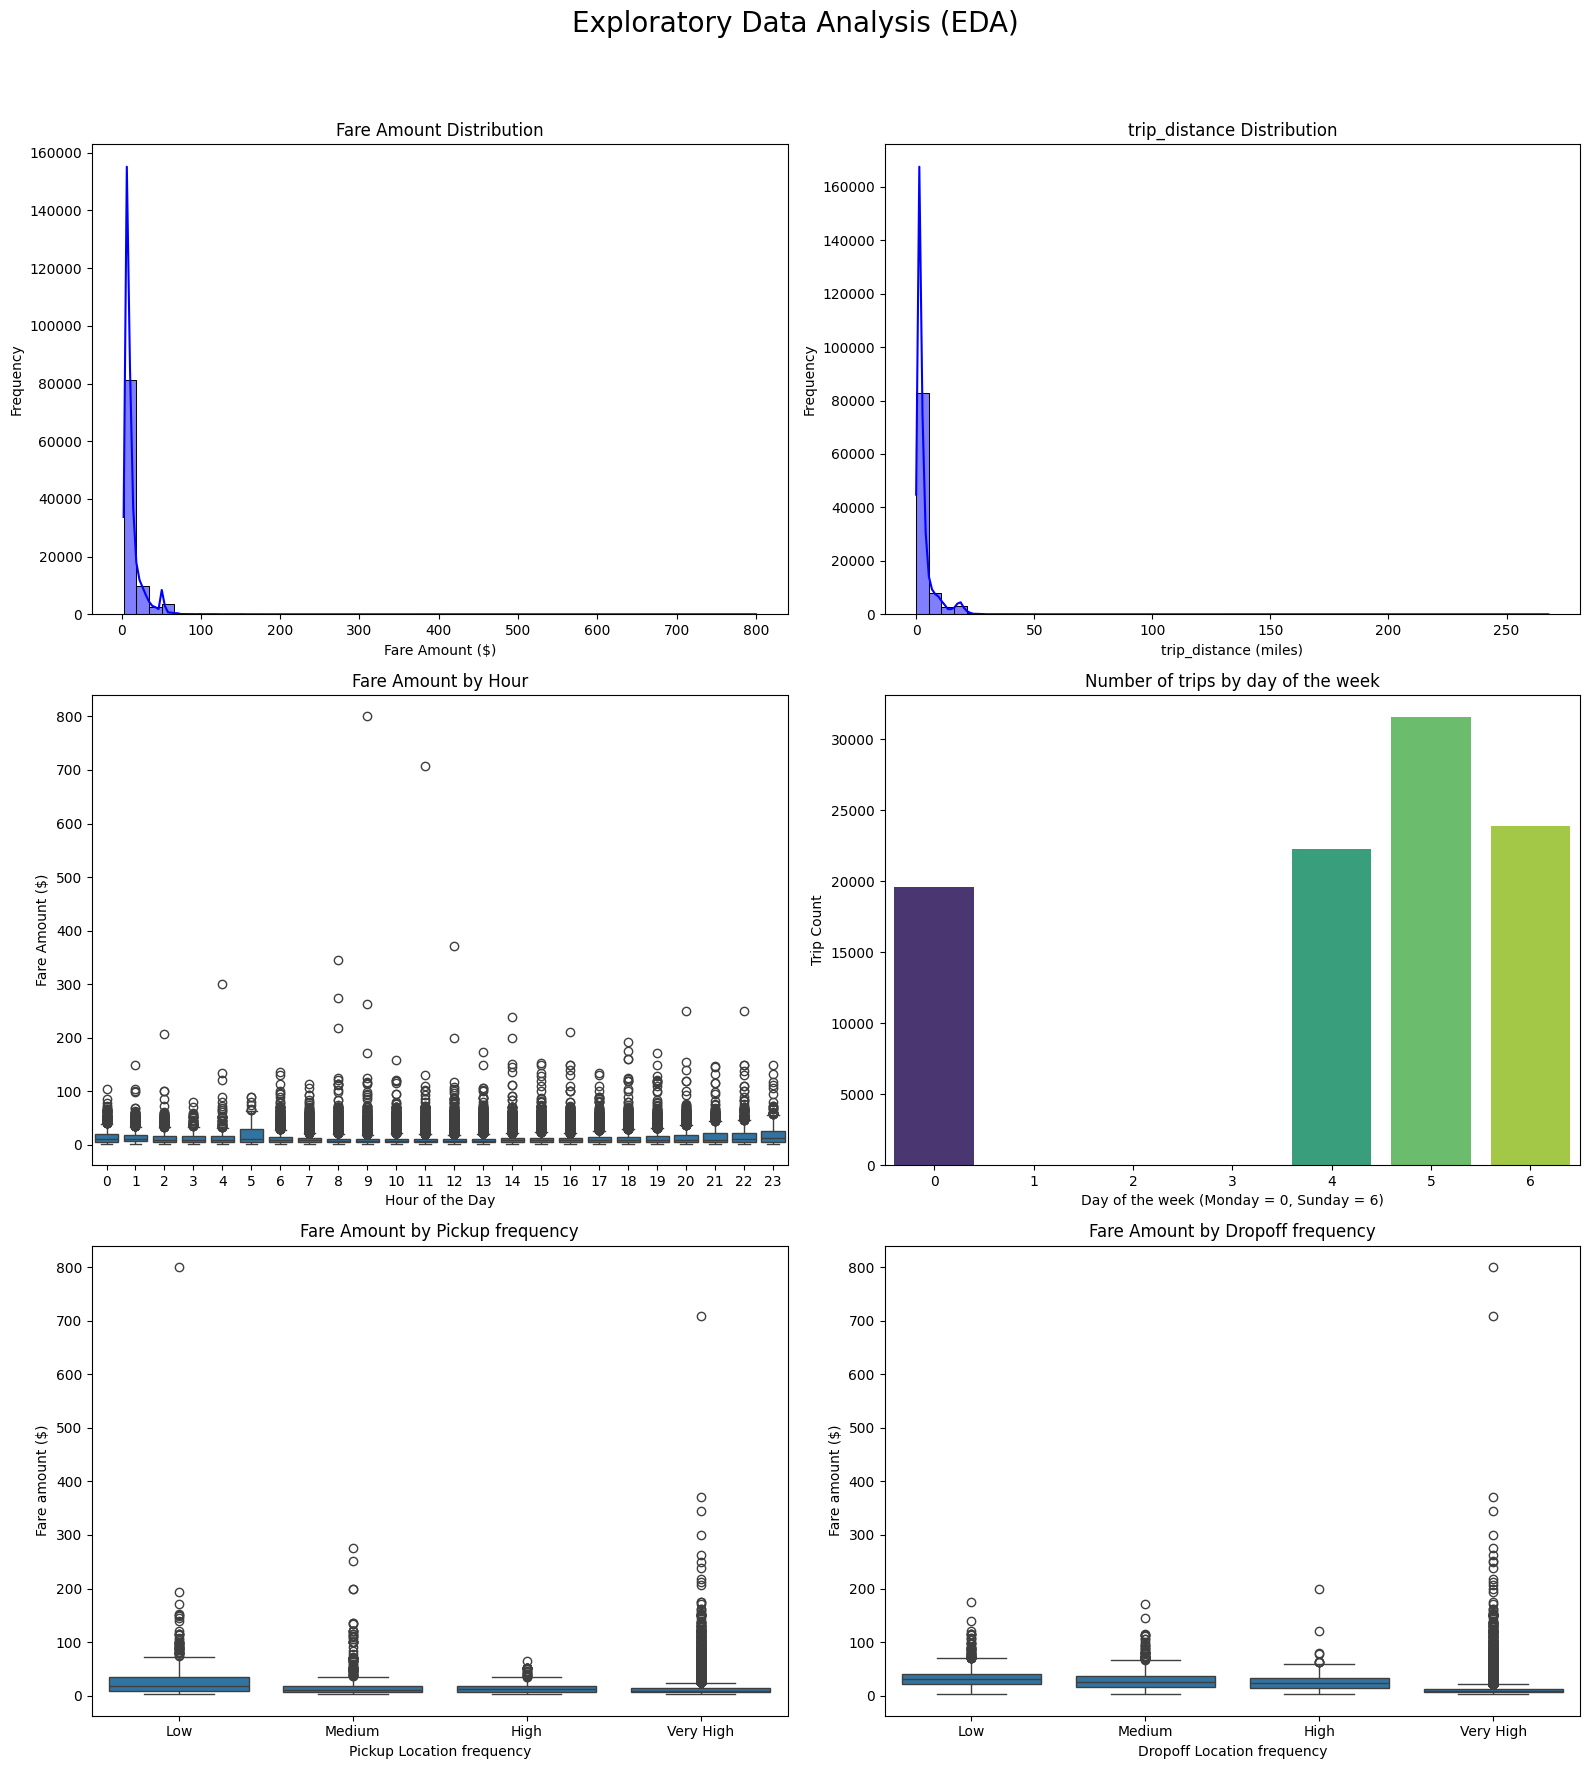

In [19]:
# Distribution
fig, axes = plt.subplots(3, 2, figsize = (16, 18))
fig.suptitle("Exploratory Data Analysis (EDA)", fontsize = 20)


# Distribution of Fare amount
sns.histplot(df["fare_amount"], bins = 50, kde = True, color = 'blue', ax = axes[0, 0])
axes[0, 0].set_title("Fare Amount Distribution")
axes[0, 0].set_xlabel("Fare Amount ($)")
axes[0, 0].set_ylabel("Frequency")

# Distribution of Trip distance
sns.histplot(df["trip_distance"], bins = 50, kde = True, color = 'blue', ax = axes[0, 1])
axes[0, 1].set_title("trip_distance Distribution")
axes[0, 1].set_xlabel("trip_distance (miles)")
axes[0, 1].set_ylabel("Frequency")


# Fare amount by hour

sns.boxplot(x="hour", y="fare_amount",data = df,ax = axes[1,0])
axes[1, 0].set_title("Fare Amount by Hour")
axes[1, 0].set_xlabel("Hour of the Day")
axes[1, 0].set_ylabel("Fare Amount ($)")

# Demand by day of the week
sns.countplot(x="day_of_week",data = df, palette = "viridis" ,ax = axes[1,1])
axes[1, 1].set_title("Number of trips by day of the week")
axes[1, 1].set_xlabel("Day of the week (Monday = 0, Sunday = 6)")
axes[1, 1].set_ylabel("Trip Count")


# Fare Amount by Pickup frequecny

sns.boxplot(x="PU_freq_bin", y="fare_amount", data=df, ax = axes[2, 0])
axes[2, 0].set_title("Fare Amount by Pickup frequency")
axes[2, 0].set_xlabel("Pickup Location frequency")
axes[2, 0].set_ylabel("Fare amount ($)")

# Fare Amount by Dropoff frequecny

sns.boxplot(x="DO_freq_bin", y="fare_amount", data=df, ax = axes[2, 1])
axes[2, 1].set_title("Fare Amount by Dropoff frequency")
axes[2, 1].set_xlabel("Dropoff Location frequency")
axes[2, 1].set_ylabel("Fare amount ($)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



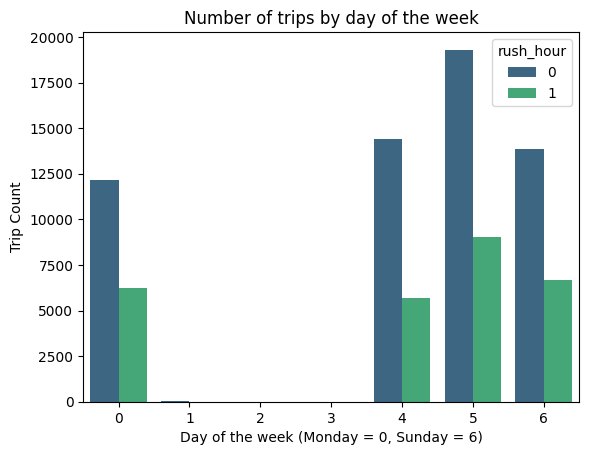

In [129]:
sns.countplot(x="day_of_week",data = df, palette = "viridis", hue='rush_hour')
plt.title("Number of trips by day of the week")
plt.xlabel("Day of the week (Monday = 0, Sunday = 6)")
plt.ylabel("Trip Count")
plt.show()

In [130]:
# Group by 'day_of_week' and calculate the mean fare
day_of_week_avg_fare = df.groupby('day_of_week')['fare_amount'].mean()
# Sort
day_of_week_avg_fare = day_of_week_avg_fare.sort_values(ascending=False)
print("Average Fare by Day of the Week:")
print(day_of_week_avg_fare)

Average Fare by Day of the Week:
day_of_week
2    15.000000
3    12.071429
1     9.500000
5     9.358876
4     9.239851
6     8.897709
0     8.891224
Name: fare_amount, dtype: float64


/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_55354/1082593069.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_of_week_avg_fare.index, y=day_of_week_avg_fare.values, palette="viridis")


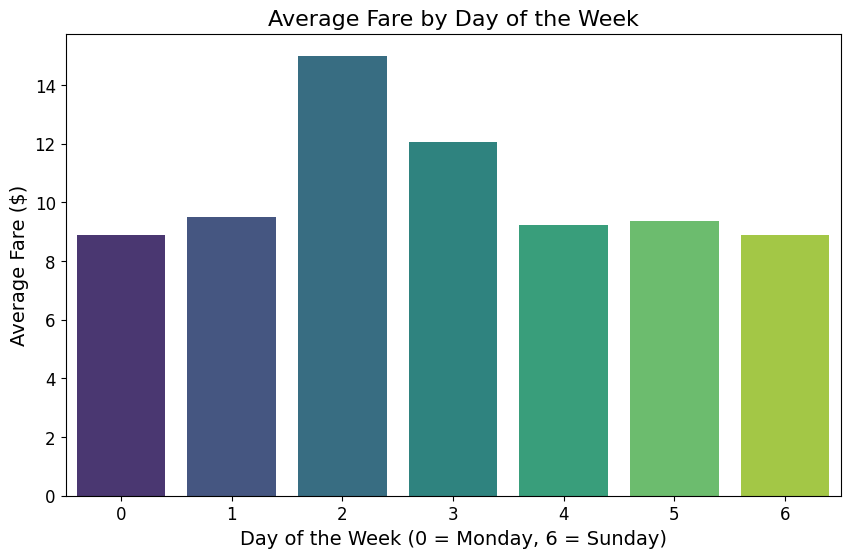

In [116]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=day_of_week_avg_fare.index, y=day_of_week_avg_fare.values, palette="viridis")
plt.title("Average Fare by Day of the Week", fontsize=16)
plt.xlabel("Day of the Week (0 = Monday, 6 = Sunday)", fontsize=14)
plt.ylabel("Average Fare ($)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the image
plt.savefig("app/static/images/average_fare_by_day.png", bbox_inches="tight")
plt.show()

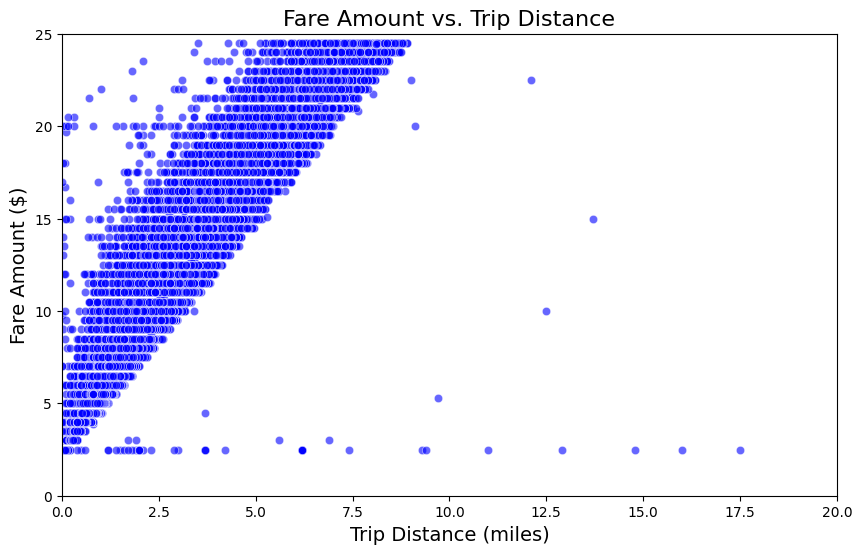

In [121]:
# Scatter plot: Fare vs. Trip Distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["trip_distance"], y=df["fare_amount"], alpha=0.6, color="blue")
plt.title("Fare Amount vs. Trip Distance", fontsize=16)
plt.xlabel("Trip Distance (miles)", fontsize=14)
plt.ylabel("Fare Amount ($)", fontsize=14)
plt.xlim(0, 20) 
plt.ylim(0, 25)  
plt.savefig("app/static/images/fare_vs_distance.png", bbox_inches="tight")
plt.show()


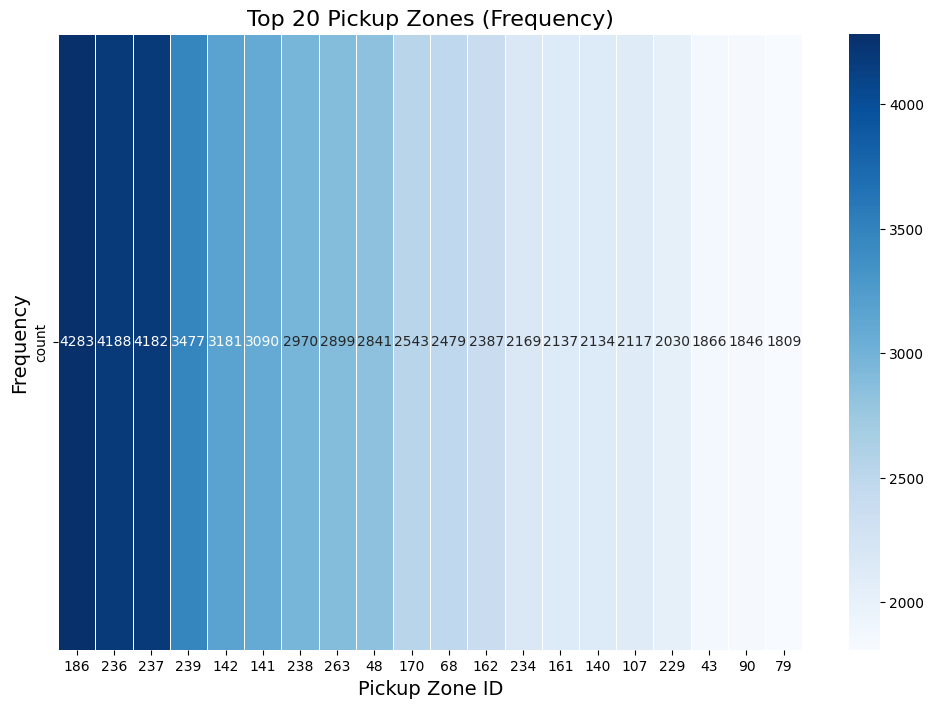

In [125]:

pickup_freq = df["PULocationID"].value_counts().head(20)  

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(pickup_freq).T, cmap="Blues", annot=True, fmt="d", linewidths=0.5)
plt.title("Top 20 Pickup Zones (Frequency)", fontsize=16)
plt.xlabel("Pickup Zone ID", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.savefig("app/static/images/pickup_frequencies.png", bbox_inches="tight")
plt.show()




## Prep for Modeling - feature selection, Scaling, encoding, spliting  - as needed

### Add Interaction Terms

In [20]:
# Interaction terms
df["distance_hour"] = df["trip_distance"] * df["hour"]
df["PU_DO_interaction"] = df["PU_freq"] * df["DO_freq"]

print("Interaction terms added: 'distance_hour' and 'PU_DO_interaction'.")

Interaction terms added: 'distance_hour' and 'PU_DO_interaction'.


In [21]:

# Define a function to create clusters
def create_location_clusters(df, n_clusters=10):
    """
    Groups pickup and dropoff locations into clusters using KMeans.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    # Clustering based on location frequencies
    df["PU_cluster"] = kmeans.fit_predict(df[["PU_freq"]])
    df["DO_cluster"] = kmeans.fit_predict(df[["DO_freq"]])

    return df

# Apply clustering
df = create_location_clusters(df, n_clusters=10)

print("Clusters created: 'PU_cluster' and 'DO_cluster'.")


Clusters created: 'PU_cluster' and 'DO_cluster'.


In [99]:
# Rush hour flag (binary feature)
def is_rush_hour(hour):
    """
    Returns 1 if the hour falls in rush hour (e.g., 7-9 AM or 4-6 PM), otherwise 0.
    """
    return 1 if (7 <= hour <= 9) or (16 <= hour <= 18) else 0

# Apply the rush hour function
df["rush_hour"] = df["hour"].apply(is_rush_hour)

print("Rush hour flag added: 'rush_hour'.")


Rush hour flag added: 'rush_hour'.


In [131]:
X = df[["trip_distance", "hour", "day_of_week", "PU_freq", "DO_freq"]]
y = df["fare_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KeyError: "['PU_freq', 'DO_freq'] not in index"

In [132]:
# Define the new feature set
X = df[[
    "trip_distance",       # Original
    "hour",                # Original
    "day_of_week",         # Original
    "PU_freq",             # Original
    "DO_freq",             # Original       
    "PU_cluster",          # Clustering
    "DO_cluster",
    "rush_hour"
                
]]

y = df["fare_amount"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




KeyError: "['PU_freq', 'DO_freq', 'PU_cluster', 'DO_cluster'] not in index"

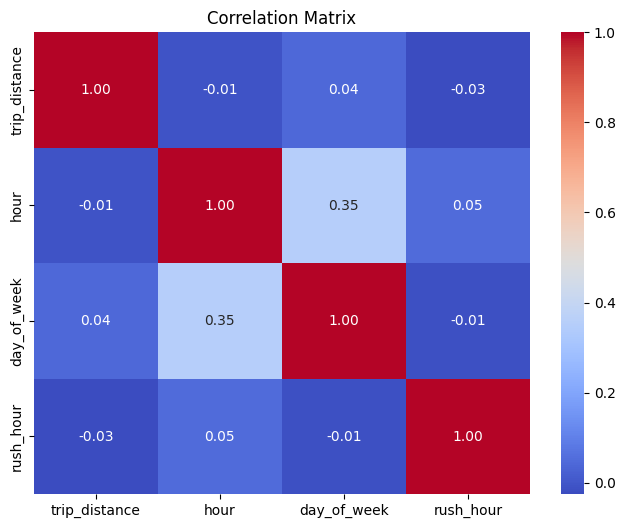

In [96]:
correlation_matrix = X.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



##  Random Forest: Before Optimization

In [97]:
# Random Forest before optimization
# Train the model with default parameters
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_train, y_train)

# Evaluate the model
y_pred_rf_default = rf_default.predict(X_test)
rf_default_metrics = {
    "RMSE": mean_squared_error(y_test, y_pred_rf_default, squared=False),
    "MAE": mean_absolute_error(y_test, y_pred_rf_default),
    "R2": r2_score(y_test, y_pred_rf_default)
}

print("Random Forest (Before Optimization):", rf_default_metrics)



Random Forest (Before Optimization): {'RMSE': np.float64(1.4141866847596083), 'MAE': np.float64(0.8861307499327632), 'R2': 0.9047117666951102}


/Users/birukzewdie/Desktop/N_Machine_Learning/NYC_Yellow_Taxi_Trip/NYC_Taxi_Trip_Fare_Prediction/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


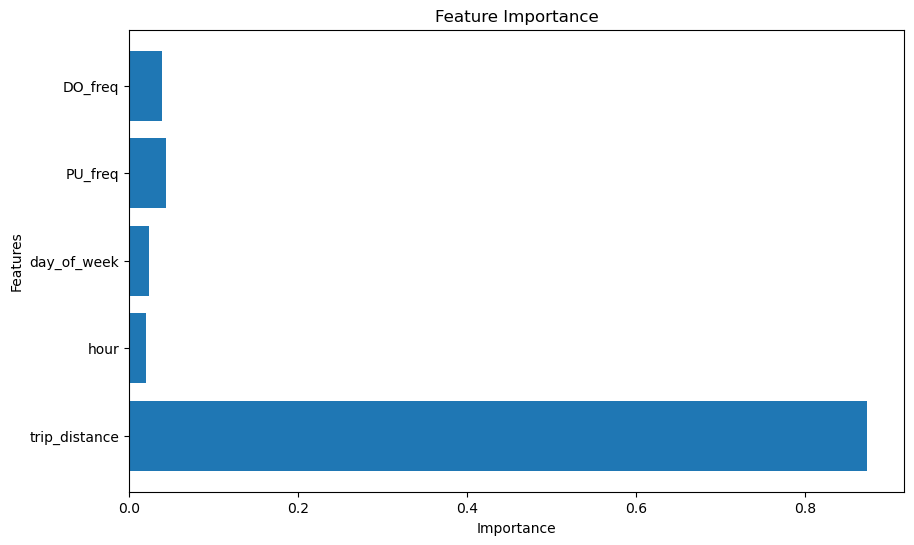

In [246]:
# Train a quick XGBoost model
model = XGBRegressor(n_estimators=50, random_state=42)
model.fit(X, y)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## Random Forest After Optimization


In [253]:
# Hyperparameter tuning for Random Forest

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best parameters and model
rf_best_model = rf_grid_search.best_estimator_
y_pred_rf_optimized = rf_best_model.predict(X_test)

# Evaluate the optimized model
rf_optimized_metrics = {
    "RMSE": mean_squared_error(y_test, y_pred_rf_optimized, squared=False),
    "MAE": mean_absolute_error(y_test, y_pred_rf_optimized),
    "R2": r2_score(y_test, y_pred_rf_optimized)
}

print("Random Forest (After Optimization):", rf_optimized_metrics)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


KeyboardInterrupt: 

## XGBoost: Before Optimization

In [262]:
# XGBoost before optimization
# Train the model with default parameters
xgb_default = XGBRegressor(random_state=42)
xgb_default.fit(X_train, y_train)

# Evaluate the model
y_pred_xgb_default = xgb_default.predict(X_test)
xgb_default_metrics = {
    "RMSE": mean_squared_error(y_test, y_pred_xgb_default, squared=False),
    "MAE": mean_absolute_error(y_test, y_pred_xgb_default),
    "R2": r2_score(y_test, y_pred_xgb_default)
}

print("XGBoost (Before Optimization):", xgb_default_metrics)


XGBoost (Before Optimization): {'RMSE': 4.3331675353916665, 'MAE': 1.2506415926054177, 'R2': 0.8960047079951278}


## XGBoost After Optimization

In [254]:
# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Best parameters and model
xgb_best_model = xgb_grid_search.best_estimator_
y_pred_xgb_optimized = xgb_best_model.predict(X_test)

# Evaluate the optimized model
xgb_optimized_metrics = {
    "RMSE": mean_squared_error(y_test, y_pred_xgb_optimized, squared=False),
    "MAE": mean_absolute_error(y_test, y_pred_xgb_optimized),
    "R2": r2_score(y_test, y_pred_xgb_optimized)
}

print("XGBoost (After Optimization):", xgb_optimized_metrics)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
XGBoost (After Optimization): {'RMSE': 4.160569749995882, 'MAE': 1.3210347510153722, 'R2': 0.9041243477307351}


## Compare

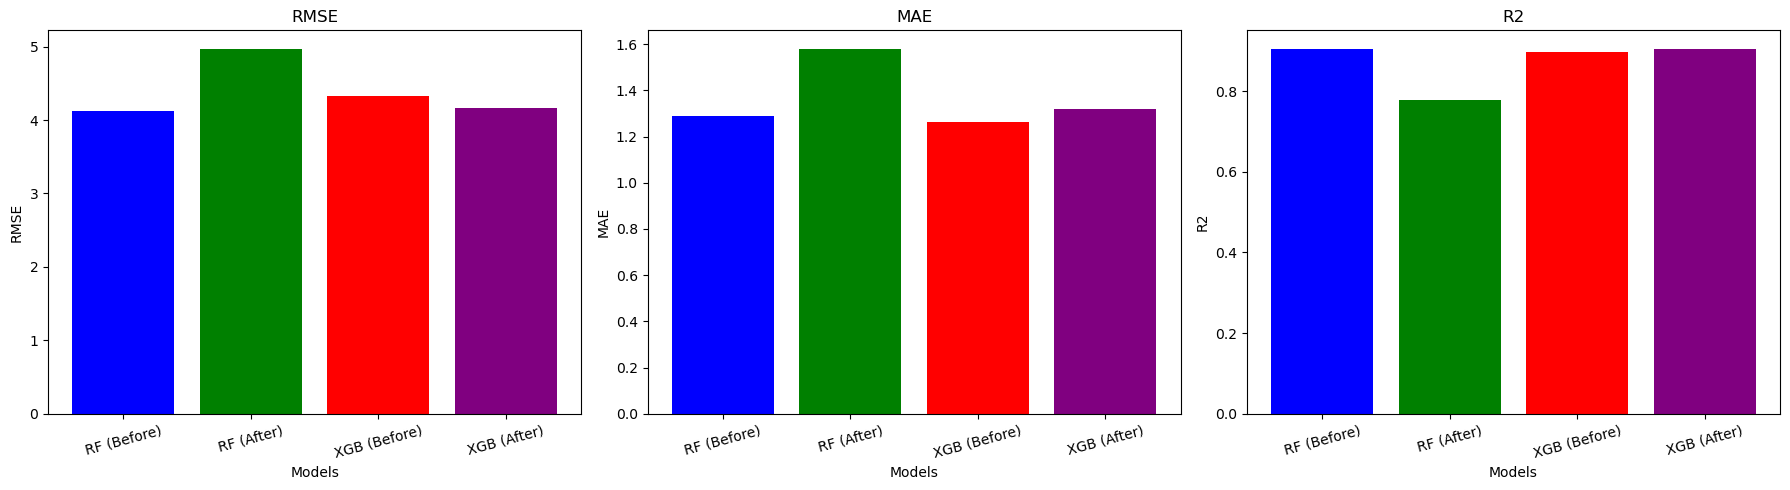

In [255]:


# Combine results for comparison
results = {
    "Model": ["RF (Before)", "RF (After)", "XGB (Before)", "XGB (After)"],
    "RMSE": [rf_default_metrics["RMSE"], rf_optimized_metrics["RMSE"], xgb_default_metrics["RMSE"], xgb_optimized_metrics["RMSE"]],
    "MAE": [rf_default_metrics["MAE"], rf_optimized_metrics["MAE"], xgb_default_metrics["MAE"], xgb_optimized_metrics["MAE"]],
    "R2": [rf_default_metrics["R2"], rf_optimized_metrics["R2"], xgb_default_metrics["R2"], xgb_optimized_metrics["R2"]]
}

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ["RMSE", "MAE", "R2"]

for i, metric in enumerate(metrics):
    axes[i].bar(results["Model"], results[metric], color=["blue", "green", "red", "purple"])
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Models")
    axes[i].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()


In [121]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Trains the given model and evaluates its performance on the test set.
    Returns the evaluation metrics and predictions.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {"model": model, "rmse": rmse, "mae": mae, "r2": r2, "y_pred": y_pred}

In [122]:
def plot_model_comparison(results):
    """
    Plots a bar chart comparing the RMSE, MAE, and R² for different models.
    """
    models = [result["name"] for result in results]
    rmse = [result["metrics"]["rmse"] for result in results]
    mae = [result["metrics"]["mae"] for result in results]
    r2 = [result["metrics"]["r2"] for result in results]

    # Plot RMSE
    plt.figure(figsize=(12, 6))
    x = np.arange(len(models))
    width = 0.3

    plt.bar(x - width, rmse, width=0.3, label="RMSE")
    plt.bar(x, mae, width=0.3, label="MAE")
    plt.bar(x + width, r2, width=0.3, label="R²")

    plt.xticks(x, models)
    plt.ylabel("Error / Score")
    plt.title("Model Performance Comparison")
    plt.legend()
    plt.show()



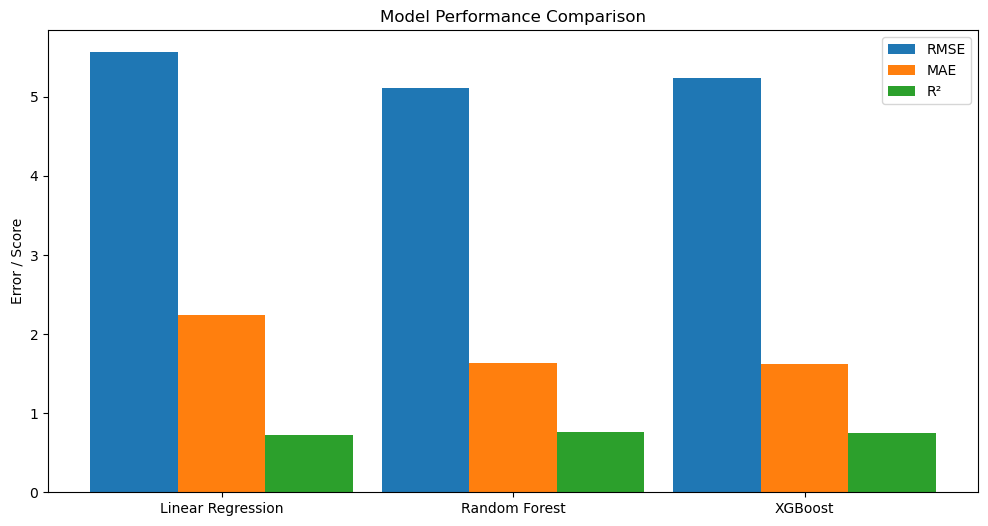

In [123]:
# Define the models to compare
models = [
    {"name": "Linear Regression", "model": LinearRegression()},
    {"name": "Random Forest", "model": RandomForestRegressor(n_estimators=100, random_state=42)},
    {"name": "XGBoost", "model": XGBRegressor(n_estimators=100, random_state=42)}
]

# Train and evaluate each model
results = []
for m in models:
    metrics = train_and_evaluate_model(m["model"], X_train, X_test, y_train, y_test)
    results.append({"name": m["name"], "metrics": metrics})

# Plot the comparison
plot_model_comparison(results)

In [128]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Trains the given model and evaluates its performance on the test set.
    Returns the evaluation metrics and predictions.
    """
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {"rmse": rmse, "mae": mae, "r2": r2}

# Models to evaluate
models = [
    {"name": "Linear Regression", "model": LinearRegression()},
    {"name": "Random Forest", "model": RandomForestRegressor(n_estimators=300, random_state=42)},
    {"name": "XGBoost", "model": XGBRegressor(n_estimators=100, random_state=42)}
]

# Train and evaluate each model
results = []
for m in models:
    metrics = train_and_evaluate_model(m["model"], X_train, X_test, y_train, y_test)
    results.append({"name": m["name"], "metrics": metrics})

# Display the results
for result in results:
    print(f"{result['name']} - RMSE: {result['metrics']['rmse']:.2f}, "
          f"MAE: {result['metrics']['mae']:.2f}, "
          f"R²: {result['metrics']['r2']:.2f}")






Linear Regression - RMSE: 5.56, MAE: 2.24, R²: 0.72
Random Forest - RMSE: 5.11, MAE: 1.63, R²: 0.76
XGBoost - RMSE: 5.23, MAE: 1.62, R²: 0.75


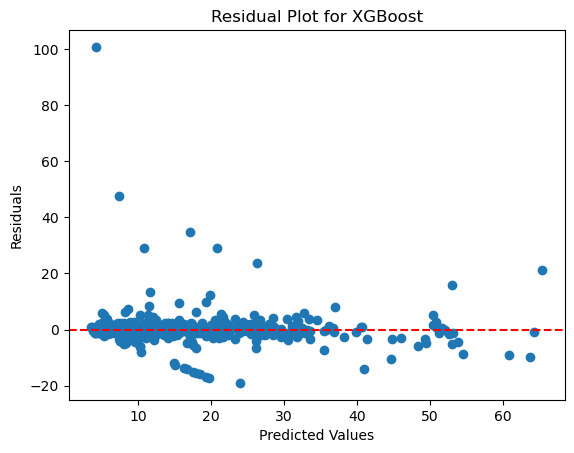

In [140]:
residuals = y_test - xgb_best_model.predict(X_test)
plt.scatter(xgb_best_model.predict(X_test), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for XGBoost")
plt.show()


# Neural Nets


In [263]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [276]:
# Step 2: Build the Neural Network
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(16, activation='relu'),  # Hidden layer
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])



In [277]:
# Step 3: Train the Model
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test),
                    epochs=50, batch_size=32, verbose=1)

# Step 4: Evaluate the Model
y_pred_nn = model.predict(X_test_scaled).flatten()  # Flatten to match y_test shape




Epoch 1/50
2432/2432 [==============================] - 1s 544us/step - loss: 114.9242 - mae: 5.8263 - val_loss: 26.5881 - val_mae: 2.7924
Epoch 2/50
2432/2432 [==============================] - 1s 495us/step - loss: 28.3660 - mae: 2.3843 - val_loss: 21.7198 - val_mae: 2.1294
Epoch 3/50
2432/2432 [==============================] - 1s 493us/step - loss: 26.5477 - mae: 2.0768 - val_loss: 20.8647 - val_mae: 1.9266
Epoch 4/50
2432/2432 [==============================] - 1s 493us/step - loss: 25.7898 - mae: 1.9080 - val_loss: 20.4758 - val_mae: 1.8268
Epoch 5/50
2432/2432 [==============================] - 1s 500us/step - loss: 25.3181 - mae: 1.8093 - val_loss: 20.1684 - val_mae: 1.7438
Epoch 6/50
2432/2432 [==============================] - 1s 536us/step - loss: 25.0973 - mae: 1.7556 - val_loss: 19.9944 - val_mae: 1.7126
Epoch 7/50
2432/2432 [==============================] - 1s 499us/step - loss: 24.9427 - mae: 1.7187 - val_loss: 19.7991 - val_mae: 1.6451
Epoch 8/50
2432/2432 [===========

In [278]:
# Calculate metrics
nn_metrics = {
    "RMSE": mean_squared_error(y_test, y_pred_nn, squared=False),
    "MAE": mean_absolute_error(y_test, y_pred_nn),
    "R2": r2_score(y_test, y_pred_nn)
}

print("Neural Network Metrics:", nn_metrics)



Neural Network Metrics: {'RMSE': 4.507863926087771, 'MAE': 1.627085653066047, 'R2': 0.8874503073671001}


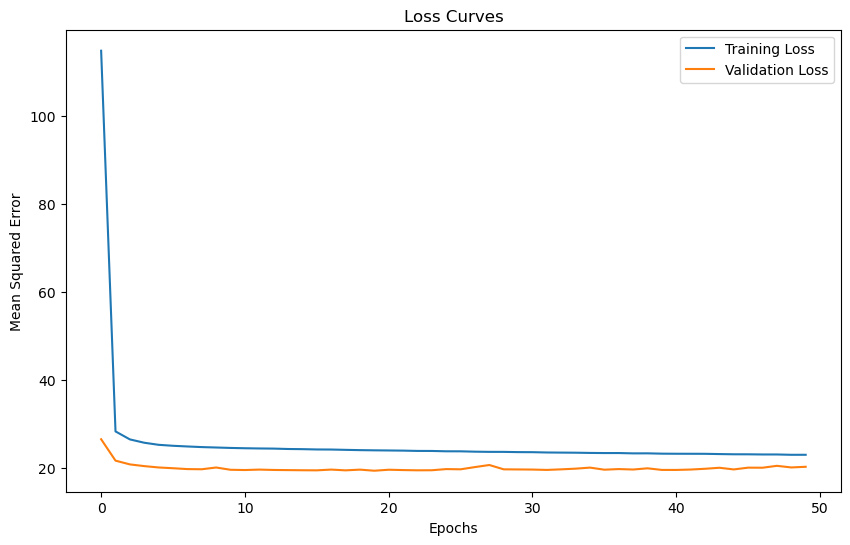

In [279]:
# Step 5: Visualize Training History

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

## Random Forest for optimization

In [35]:
import os

os.chdir("../")

In [100]:
import pickle
from src.config import API_URL, API_PARAMS, RANDOM_FOREST_PARAMS, MODEL_PATH
from sklearn.preprocessing import StandardScaler

X = df[["trip_distance", "hour", "day_of_week", "rush_hour"]]
y = df["fare_amount"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check dataset shape
print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

Training Data Shape: (69924, 4)
Test Data Shape: (17482, 4)


In [101]:
# Train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)

rf_model.fit(X_train, y_train)

# Feature importance
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importances)


         Feature  Importance
0  trip_distance    0.989342
1           hour    0.005860
2    day_of_week    0.004331
3      rush_hour    0.000467


In [102]:
# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation Metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")


RMSE: 1.0881043811241502
MAE: 0.746132980005942
R²: 0.9435353122519586


/Users/birukzewdie/Desktop/N_Machine_Learning/NYC_Yellow_Taxi_Trip/NYC_Taxi_Trip_Fare_Prediction/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [103]:
y_baseline_pred = [y.mean()] * len(y)

# Calculate RMSE and MAE for baseline
baseline_rmse = mean_squared_error(y, y_baseline_pred, squared=False)
baseline_mae = mean_absolute_error(y, y_baseline_pred)

print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Baseline MAE: {baseline_mae:.2f}")

Baseline RMSE: 4.58
Baseline MAE: 3.56


/Users/birukzewdie/Desktop/N_Machine_Learning/NYC_Yellow_Taxi_Trip/NYC_Taxi_Trip_Fare_Prediction/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [104]:
rmse_improvement = ((baseline_rmse - 2.70) / baseline_rmse) * 100
print(f"RMSE Improvement: {rmse_improvement:.2f}%")


RMSE Improvement: 41.06%


/var/folders/h4/4f1dd3392y134gkcvw6sfk1r0000gn/T/ipykernel_55354/207562210.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="coolwarm")


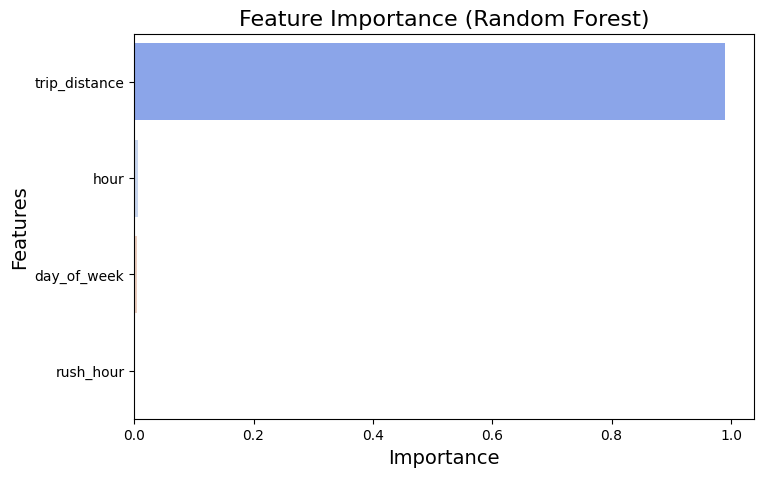

In [123]:
features = ["trip_distance", "hour", "day_of_week", "rush_hour"]
importances = rf_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette="coolwarm")
plt.title("Feature Importance (Random Forest)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)

# Save the image
plt.savefig("app/static/images/feature_importance.png", bbox_inches="tight")
plt.show()

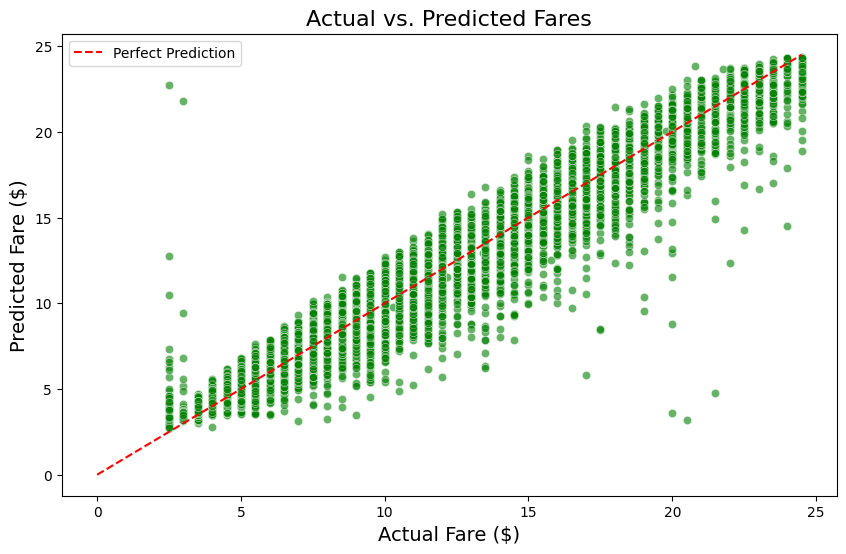

R² Score: 0.94


In [124]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="green")
plt.title("Actual vs. Predicted Fares", fontsize=16)
plt.xlabel("Actual Fare ($)", fontsize=14)
plt.ylabel("Predicted Fare ($)", fontsize=14)

# Add a reference line
max_fare = max(max(y_test), max(y_pred))
plt.plot([0, max_fare], [0, max_fare], linestyle="--", color="red", label="Perfect Prediction")
plt.legend()

# Save the image
plt.savefig("app/static/images/actual_vs_predicted.png", bbox_inches="tight")
plt.show()

# Print R² score for context
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
